# Implementation of a pure (non-hybrid) Quantum Neural Network with entangled states
## The notebook below implements a multi-layered perceptron based Neural Network with hidden layers implemented replicated by varational circuits
    - The implementation is a muticlass classifier that tries to predict the 3 output classes
    - This is a novel algorithm that is not implemented on the pennylane tutorial website
    - The dataset used is IRIS flower classification dataset, with 5 input features and 3 output classes
    - The performance is evaluated on the test dataset with train-test split of 75%:25%


In [11]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer
from pennylane.init import strong_ent_layers_uniform
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.templates import AmplitudeEmbedding


## Defining the Model Parameters

In [12]:
n_qubits = 3 # for representing three output classes
num_layers = 3 # number of hidden layers of the quantum neural network
q_depth = num_layers # Circuit depth which is also equal to num_layers
l_r = 0.1 # Learning rate for the optimizer
num_epochs = 100 # number of training epochs

## Instantiating our quantum simulator at the backend

In [13]:
dev = qml.device("default.qubit", wires=n_qubits)

## Defining the hidden quantum layer which will be repeated num_layers times i.e. 6 times

In [14]:
@qml.qnode(dev)
def quantum_net(weights, x=None):
    """
    The variational quantum circuit.
    """
    AmplitudeEmbedding(x, wires=range(n_qubits),normalize=True, pad=0.3)
    # AngleEmbedding(x, wires=range(n_qubits))
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return tuple(qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits))

## Representation of a single layered QNN

## Defining the cost function of the classifier i.e. categorical crossentropy


In [15]:
def softmax(X):
    prob = np.exp(X)
    probs = prob / np.sum(prob, axis=1, keepdims=True)
    return probs
def cost(thetas, X, actual_labels):
    b = X.shape[0]
    yhats = []
    for i in range(b):
        yhat = quantum_net(thetas[0], x=X[i])
        # print(quantum_net.draw())
        yhats.append(yhat)
    st = np.stack(yhats)
    st_prob = softmax(st)
    y = np.zeros((actual_labels.shape[0], n_qubits))
    y[np.arange(actual_labels.shape[0]), actual_labels] = 1
    return -np.mean(y*np.log(st_prob))

## Implementing the training procedure

### 1. Loading the dataset

In [16]:
num_features = 4
data = np.loadtxt("multiclass_classification/iris.csv", delimiter=",")
X = data[:, 0:num_features]
X_pad = X
print("First X sample:", X_pad[0])

First X sample: [5.1 3.5 1.4 0.2]


### 2. Normalizing the dataset and creating training and validation(test) set

In [17]:
# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

Y = data[:, -1].astype(int)

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = X_pad[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = X_pad[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X_pad[index[:num_train]]
X_val = X_pad[index[num_train:]]

First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]


### 3. Initializing the weights and optimization routing for the quantum neural network

In [18]:
theta_weights = strong_ent_layers_uniform(num_layers, n_qubits, seed=42)
theta_bias = 0.0
theta_init = (theta_weights, theta_bias)  # initial weights
opt = AdamOptimizer(l_r)
batch_size = 10
var = theta_init

### 4. Full Circuit Representation

In [19]:
yhat = quantum_net(theta_init[0], x=X_train[0])
print(quantum_net.draw())

 0: ──╭QubitStateVector(M0)──Rot(2.353, 5.974, 4.599)──╭C───────────────────────────────╭X──Rot(4.449, 0.129, 6.094)──╭C──╭X───Rot(2.714, 1.83, 3.844)────────────────────────────╭C──────╭X──┤ ⟨Z⟩ 
 1: ──├QubitStateVector(M0)──Rot(3.761, 0.98, 0.98)────╰X──╭C──Rot(5.23, 1.334, 1.142)──│─────────────────────────────│───╰C──╭X────────────────────────Rot(0.876, 1.836, 2.302)──╰X──╭C──│───┤ ⟨Z⟩ 
 2: ──╰QubitStateVector(M0)──Rot(0.365, 5.442, 3.777)──────╰X───────────────────────────╰C──Rot(1.152, 1.912, 3.297)──╰X──────╰C────────────────────────Rot(2.866, 4.933, 1.255)──────╰X──╰C──┤ ⟨Z⟩ 
M0 =
[0.67602006 0.32635451 0.59443143 0.27973244 0.03496655 0.03496655
 0.03496655 0.03496655]



### 5. Initiating the training loop

In [20]:
cost_list, train_acc, test_acc = [], [], []
for it in range(num_epochs):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)
    predictions_train = [quantum_net(var[0], x=f) for f in feats_train]
    predictions_val = [quantum_net(var[0], x=f) for f in feats_val]
    pred_train_labels = np.argmax(softmax(predictions_train), axis=1)
    pred_val_labels = np.argmax(softmax(predictions_val), axis=1)
    # Compute accuracy on train and validation set
    acc_train = np.mean(Y_train==pred_train_labels)
    acc_val = np.mean(Y_val==pred_val_labels)
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc Test: {:0.7f} "
        "".format(it + 1, cost(var, X, Y), acc_train, acc_val)
    )
    cost_list.append(cost(var, X, Y)), train_acc.append(acc_train), test_acc.append(acc_val)
    if acc_val>=0.90 and acc_train>=0.90 and it>=50:
        break


Iter:     1 | Cost: 0.4103933 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:     2 | Cost: 0.4003187 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:     3 | Cost: 0.3921734 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:     4 | Cost: 0.3859017 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:     5 | Cost: 0.3826671 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:     6 | Cost: 0.3816475 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:     7 | Cost: 0.3801277 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:     8 | Cost: 0.3774603 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:     9 | Cost: 0.3744315 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:    10 | Cost: 0.3705041 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:    11 | Cost: 0.3656563 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:    12 | Cost: 0.3602021 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:    13 | Cost: 0.3542129 | Acc train: 0.3392857 | Acc Test: 0.3157895 
Iter:    14 

In [24]:
costs_list = [x.item() for x in cost_list]

In [30]:
len(iters)

76

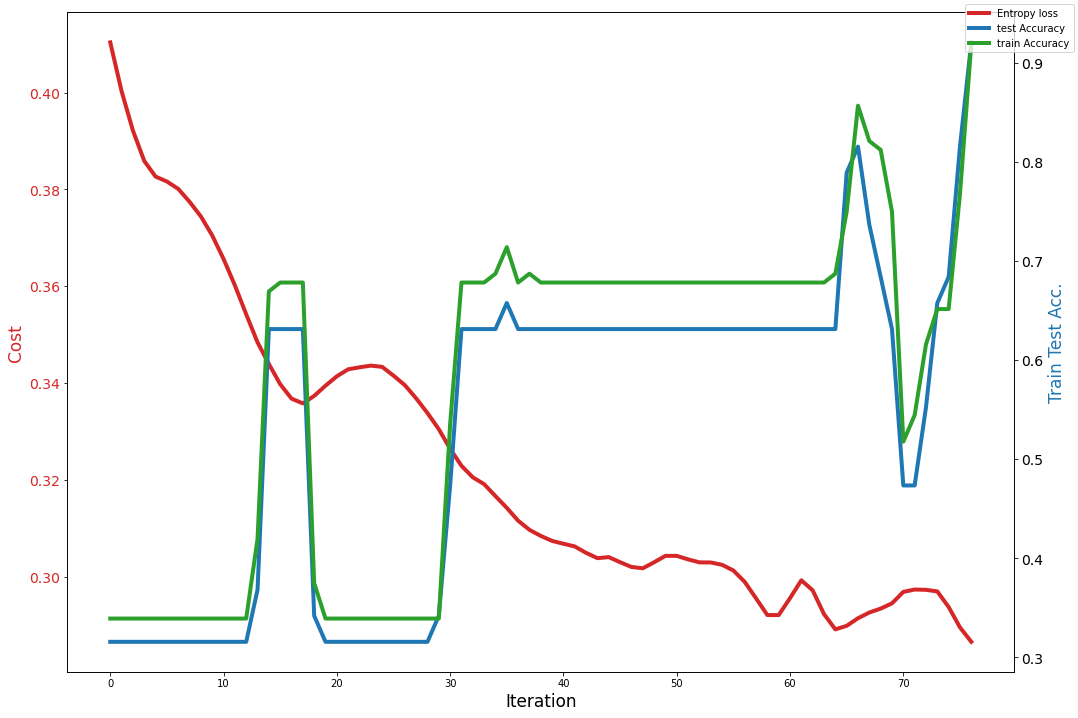

In [36]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 10))
iters = np.arange(0, it + 1, 1)
colors = ["tab:red", "tab:blue", "tab:green"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs_list, color=colors[0], linewidth=4, label='Entropy loss')
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Train Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4, label='test Accuracy')
ax2.plot(iters, train_acc, color=colors[2], linewidth=4, label='train Accuracy')


ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

plt.grid(False)
plt.tight_layout()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)

fig.legend(lines, labels)
plt.show()
plt.show()

In [38]:
!pip3 install sklearn
from sklearn.metrics import confusion_matrix

Processing /Users/sujitkhanna/Library/Caches/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074/sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-0.23.2-cp37-cp37m-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached joblib-0.17.0-py3-none-any.whl (301 kB)


In [39]:
print(confusion_matrix(Y_val,pred_val_labels))

[[12  0  0]
 [ 0 11  3]
 [ 0  0 12]]


In [42]:
from sklearn.metrics import classification_report, jaccard_score
print(classification_report(Y_val,pred_val_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.79      0.88        14
           2       0.80      1.00      0.89        12

    accuracy                           0.92        38
   macro avg       0.93      0.93      0.92        38
weighted avg       0.94      0.92      0.92        38



In [43]:
jaccard_score(Y_val, pred_val_labels, average='weighted')

0.8578947368421053